## Welcome
This is an examplary analysis of the connectivity of the released part of the rat SSCx model of Blue Brain.
It illustrates the use of the "bluepysnap" and "conntility" packages to analyze its connectivity on the cellular level, i.e. as a graph with neurons as nodes and edges between them

### Setup
This file is packaged together with the actual circuit model on Zenodo. 
To run the analyses, you will first have to uncompress the archive containing the circuit model. After unpacking, you will find a file called "circuit_config.json". That file is for the purpose of the analyses the representation of the entire circuit. Note its path, and fill it in in the next cell as prompted.

The analysis packages conntility and bluepysnap can be found on the [Blue Brain github pages](https://github.com/BlueBrain).

Part of the data repository that contained the circuit and this file was "analysis.tar". Extract its contents to ./analysis

Then, we begin by loading the required packages, and listing the different types of connectivity in the model. In the Sonata file format used to describe the model, connectivity is broken up into individual "EdgeSets" that represent different types of connections. Each has a name. Our model has the following EdgeSets:
 - S1nonbarrel_neurons__S1nonbarrel_neurons__chemical: The connections between the neurons in the model according to the Reimann et al., 2015 algorithm for local connectivity
 - midrange__S1nonbarrel_neurons__chemical: The connections between the neurons in the model according to the Reimann et al., 2019 algorithm for long range connectivity. Note: As this is long-range connectivity and this part of the model is rather small, there are not many connections.
 - external_S1nonbarrel_neurons__S1nonbarrel_neurons__chemical: Connections from parts of the full model that are not part of this release to neurons that are part of the release according to Reimann et al., 2015. This means that the _source_ of this connectivity is a set of "virtual" neurons that are associated with locations and types, but no morphologies or biophysical models. Hence, they cannot be simulated. Yet, their synapses can serve for certain types of stimuli.
 - external_midrange__S1nonbarrel_neurons__chemical: Connections from parts of the full model that are not part of this release to neurons that are part of the release according to Reimann et al., 2019. Same caveats as the previous.
 - POm__S1nonbarrel_neurons__chemical: Connections from the POm nucleus to neurons in the released model. The sources are also "virtual", hence the same caveats apply.
 - VPM__S1nonbarrel_neurons__chemical: Connections from the VPM nucleus to neurons in the released model. The sources are also "virtual", hence the same caveats apply.

In [1]:
import conntility
import pandas
import numpy
import bluepysnap as snap

from matplotlib import pyplot as plt

# !!! FILL IN LOCATION OF circuit_config.json HERE !!!
cfg_json = "circuit_config.json"

# Load circuit and list edge sets
circ = snap.Circuit(cfg_json)
for con_name, con in circ.edges.items():
    print("""
    Connectome {0} connects
        {1} and {2}
    """.format(con_name, con.source.name, con.target.name))



    Connectome POm__S1nonbarrel_neurons__chemical connects
        POm and S1nonbarrel_neurons
    

    Connectome S1nonbarrel_neurons__S1nonbarrel_neurons__chemical connects
        S1nonbarrel_neurons and S1nonbarrel_neurons
    

    Connectome VPM__S1nonbarrel_neurons__chemical connects
        VPM and S1nonbarrel_neurons
    

    Connectome external_S1nonbarrel_neurons__S1nonbarrel_neurons__chemical connects
        S1nonbarrel_neurons and S1nonbarrel_neurons
    

    Connectome external_midrange__S1nonbarrel_neurons__chemical connects
        S1nonbarrel_neurons and S1nonbarrel_neurons
    

    Connectome midrange__S1nonbarrel_neurons__chemical connects
        S1nonbarrel_neurons and S1nonbarrel_neurons
    


Let's load one of the connectomes for analysis. 
Results will be easies to understand for "S1nonbarrel_neurons__S1nonbarrel_neurons__chemical", i.e. the local recurrent connectivity within the model.

In addition to the structue of the connectome, we can load the anatomical and biophysical properties of the synapses.
We begin by listing the available properties.

In [2]:
# Name of the edge set to load.
connectome="S1nonbarrel_neurons__S1nonbarrel_neurons__chemical"

circ.edges[connectome].property_names

{'@source_node',
 '@target_node',
 'afferent_center_x',
 'afferent_center_y',
 'afferent_center_z',
 'afferent_section_id',
 'afferent_section_pos',
 'afferent_section_type',
 'afferent_segment_id',
 'afferent_segment_offset',
 'afferent_surface_x',
 'afferent_surface_y',
 'afferent_surface_z',
 'conductance',
 'conductance_scale_factor',
 'decay_time',
 'delay',
 'depression_time',
 'efferent_center_x',
 'efferent_center_y',
 'efferent_center_z',
 'efferent_section_id',
 'efferent_section_pos',
 'efferent_section_type',
 'efferent_segment_id',
 'efferent_segment_offset',
 'efferent_surface_x',
 'efferent_surface_y',
 'efferent_surface_z',
 'facilitation_time',
 'n_rrp_vesicles',
 'spine_length',
 'syn_type_id',
 'u_hill_coefficient',
 'u_syn'}

We are interested in the strengths of connections. So we will load "conductance", which is an imperfect, but reasonable proxy for strength.

However, the circuit has multiple synaptic connections between the same pair of neurons! To represent this as an adjacency matrix, we must define how the list of multiple values is turned into a single value representing. 

We use "count", which will yield the number of synapses in a connection, i.e. the structural strength of the connection; and "sum", i.e. the total maximum conductance or the functional strength.

In [3]:
# A dict defines which node (neuron) properties to load. Here, we load:
# The coordinates of their somas in the standard coordinate system (i.e. x is anterior-posterior, etc.)
# The morphological type (mtype) of neurons
# 
# For more features of the "load_config" dict, check the conntility documentation
#
# Note this is the _node_ properties to load. Edge properties to load are define below.
to_load = {
    "loading":{
      "properties": ["x", "y", "z", "mtype"]
    }
}

C = conntility.ConnectivityMatrix.from_bluepy(circ, to_load,
                                              connectome=connectome,
                                              load_full=True,
                                              edge_property="conductance", agg_func=["count", "sum"],
                                              chunk=5000000)
# We can save the results to an hdf5 file, if we want, for future use
C.to_h5("O1_fun_con_mat.h5")

100%|██████████| 82/82 [01:52<00:00,  1.37s/it]


In [4]:
# If we saved the "ConnectivityMatrix" to an hdf5 file previously, this is how we load it.
C = conntility.ConnectivityMatrix.from_h5("O1_fun_con_mat.h5")

### Loaded data
The data loaded is represented as a simple adjacency matrix, with the nodes being the neurons. They are associated with the properties specified in the "load_cfg" above.

.matrix accesses the (sparse) adjacency matrix. Its values will be the default edge property. This can be overridded by explicitly stating which one to return.

In [5]:
C.vertices

node_ids   mtype            x            y            z
0              0  L1_DAC  4652.171846 -1930.525524 -1836.395782
1              1  L1_DAC  4977.735899 -1641.041348 -2140.579908
2              2  L1_DAC  5011.718764 -1565.779688 -2212.599874
3              3  L1_DAC  4266.789018 -1804.711830 -1531.716011
4              4  L1_DAC  4779.539653 -1259.558916 -1996.720501
...          ...     ...          ...          ...          ...
211707    211707   L5_BP  4053.191307  -663.722760 -2140.027223
211708    211708   L5_BP  4002.636889 -1382.419711 -2641.743271
211709    211709   L5_BP  4228.866737  -909.053724 -2608.261691
211710    211710   L5_BP  3961.170919 -1813.695181 -2399.488534
211711    211711   L5_BP  3856.704544  -853.672616 -2301.961282

[211712 rows x 5 columns]

In [6]:
print(C._default_edge)

print(C.matrix)  # sparse matrix: values are counts
print(C.matrix_("sum"))  # sparse matrix: values are sum of conductances

count
  (0, 52)	9
  (0, 369)	9
  (0, 700)	17
  (0, 759)	7
  (0, 849)	5
  (0, 2166)	12
  (0, 3281)	8
  (0, 3444)	8
  (0, 3520)	8
  (0, 4116)	9
  (0, 4791)	9
  (0, 5324)	7
  (0, 5329)	6
  (0, 5369)	17
  (0, 5939)	12
  (0, 6190)	14
  (0, 6430)	13
  (0, 6778)	7
  (0, 7095)	7
  (0, 7103)	12
  (0, 7381)	7
  (0, 7620)	6
  (0, 7624)	5
  (0, 7710)	6
  (0, 7783)	14
  :	:
  (211711, 26670)	2
  (211711, 28029)	3
  (211711, 28924)	3
  (211711, 31304)	3
  (211711, 39288)	5
  (211711, 91947)	6
  (211711, 109317)	4
  (211711, 112369)	27
  (211711, 114326)	7
  (211711, 114986)	5
  (211711, 126264)	5
  (211711, 130353)	12
  (211711, 130572)	13
  (211711, 142553)	11
  (211711, 146398)	2
  (211711, 175408)	6
  (211711, 175543)	10
  (211711, 175903)	9
  (211711, 181353)	12
  (211711, 185259)	8
  (211711, 188225)	12
  (211711, 193395)	12
  (211711, 193702)	11
  (211711, 199178)	18
  (211711, 209867)	10
  (0, 52)	24.872362
  (0, 369)	27.005095
  (0, 700)	4.506778
  (0, 759)	1.7338327
  (0, 849)	1.1756864
  (

### Some analysis
As part of this release, the file "connection_strength.py" should have been included. It contains a simple analysis of the mean strength of connected pairs or for all pairs. 

We can run this analysis directly:

In [7]:
from analysis.connection_strength import mean_for_all_pairs, mean_of_existing_connections

mn_all = mean_for_all_pairs(C.matrix_("count"), C.vertices)
mn_exist = mean_of_existing_connections(C.matrix_("count"), C.vertices)
print("""Mean number of connections per pair: {0}
Mean number per connected pair: {1}""".format(mn_all, mn_exist))

mn_all = mean_for_all_pairs(C.matrix_("sum"), C.vertices)
mn_exist = mean_of_existing_connections(C.matrix_("sum"), C.vertices)
print("""Mean total conductance per pair: {0}
Mean conductance per connected pair: {1}""".format(mn_all, mn_exist))

Mean number of connections per pair: 0.00908320462990484
Mean number per connected pair: 4.655139034453131
Mean total conductance per pair: 0.009034143760800362
Mean conductance per connected pair: 4.629997253417969


We can also run it on only a smaller part of the model. For example, only connectivity between the "L5_TPC:C" type neurons.


In [8]:
# Returns subpopulation where "mtype" "equals" "L5_TPC:C"
# subpopulations can be sampled based on any node property. See the conntility documentation!
subC = C.index("mtype").eq("L5_TPC:C")  

mn_all = mean_for_all_pairs(subC.matrix_("count"), subC.vertices)
mn_exist = mean_of_existing_connections(subC.matrix_("count"), subC.vertices)
print("""Mean number of connections per pair: {0}
Mean number per connected pair: {1}""".format(mn_all, mn_exist))

mn_all = mean_for_all_pairs(subC.matrix_("sum"), subC.vertices)
mn_exist = mean_of_existing_connections(subC.matrix_("sum"), subC.vertices)
print("""Mean total conductance per pair: {0}
Mean conductance per connected pair: {1}""".format(mn_all, mn_exist))

Mean number of connections per pair: 0.025980344548502725
Mean number per connected pair: 4.682113685614269
Mean total conductance per pair: 0.023395121097564697
Mean conductance per connected pair: 4.216210842132568


To exhaustively analyze all subpopulations, we do not need to iterate them manually though. This functionality is automated.
We need to express this in an "analysis_config".

Within the config, we can define more complex analyses by referencing an "atomic" analysis in a file, and then specifying a "decorator" that executes the analysis for various sub-populations.

In [9]:
analysis_specs = {
    "analyses":{
        "connection_str_of_connected": {  # A name we give to the analysis
            "source": "analysis/connection_strength.py",  # Where to find the "atomic" analysis
            "method": "mean_of_existing_connections",
            "output": "float",
            "decorators": [ # Turning it into a more complex analysis
                {
                    "name": "pathways_by_grouping_config",  # This one analyzes all M[a, b] separately!
                    "args": [{                              # where "a", "b" are sub-populations
                        "columns": ["mtype"],
                        "method": "group_by_properties"
                    }]
                }
            ]
        }
    }
}
# By calling "default" we ensure that the specified edge property is the one analyzed.
connection_fun_str = C.default("sum").analyze(analysis_specs)
connection_struc_str = C.default("count").analyze(analysis_specs)

Note that we do not need to write the analysis config every time we want to use it. We can store it in a .json file and directly execute it from there. See Analyze connectivity reach.ipynb for an example

The result of this is a dict with one entry per defined analysis. In this example, a single analysis:
 "connection_str_of_connected" shows the mean connection strength (structural or functional) of connected pairs.
 
The returned result is indexed by the name of the pre-synaptic and the post-synaptic "mtype". That grouping is what the "decorator" above specified. For more groupings check the conntility documentation.

In [10]:
name_analysis = "connection_str_of_connected"
connection_fun_str[name_analysis]

idx-mtype_pre  idx-mtype_post
L1_DAC         L1_DAC            30.979347
L1_HAC         L1_DAC            32.356689
L1_LAC         L1_DAC            35.601089
L1_NGC-DA      L1_DAC            43.094395
L1_NGC-SA      L1_DAC            33.220348
                                   ...    
L6_NGC         L6_UPC             2.626240
L6_SBC         L6_UPC            24.082378
L6_TPC:A       L6_UPC             2.126186
L6_TPC:C       L6_UPC             1.772412
L6_UPC         L6_UPC             3.033632
Length: 3600, dtype: float64

Let's visualize the results as an image plot

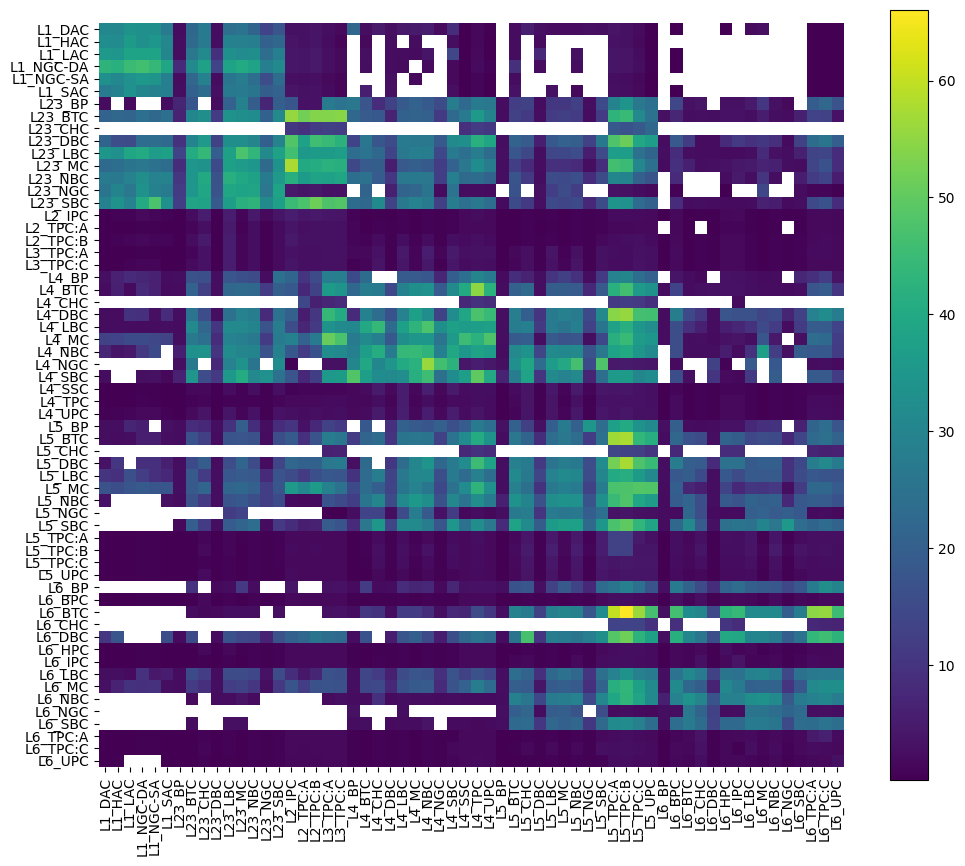

In [11]:
# Names of the MultiIndex columns used to denote the "pathway"
str_pw_post = "idx-mtype_post"
str_pw_pre = "idx-mtype_pre"

# Define plotting function
def image_plot_dataframe(df, **kwargs):
    fig = plt.figure(figsize=(12., 10.))
    ax = fig.gca()
    
    img = ax.imshow(df.values, **kwargs)
    plt.colorbar(img)
    ax.set_xticks(range(len(df.columns)))
    ax.set_xticklabels(df.columns, rotation="vertical")
    ax.set_yticks(range(len(df.index)))
    ax.set_yticklabels(df.index)
    ax.set_frame_on(False)

# And plot
fig = image_plot_dataframe(connection_fun_str[name_analysis].unstack(str_pw_post))

Some people for inexplicable reasons prefer to have the post-synaptic population along the vertical axis...

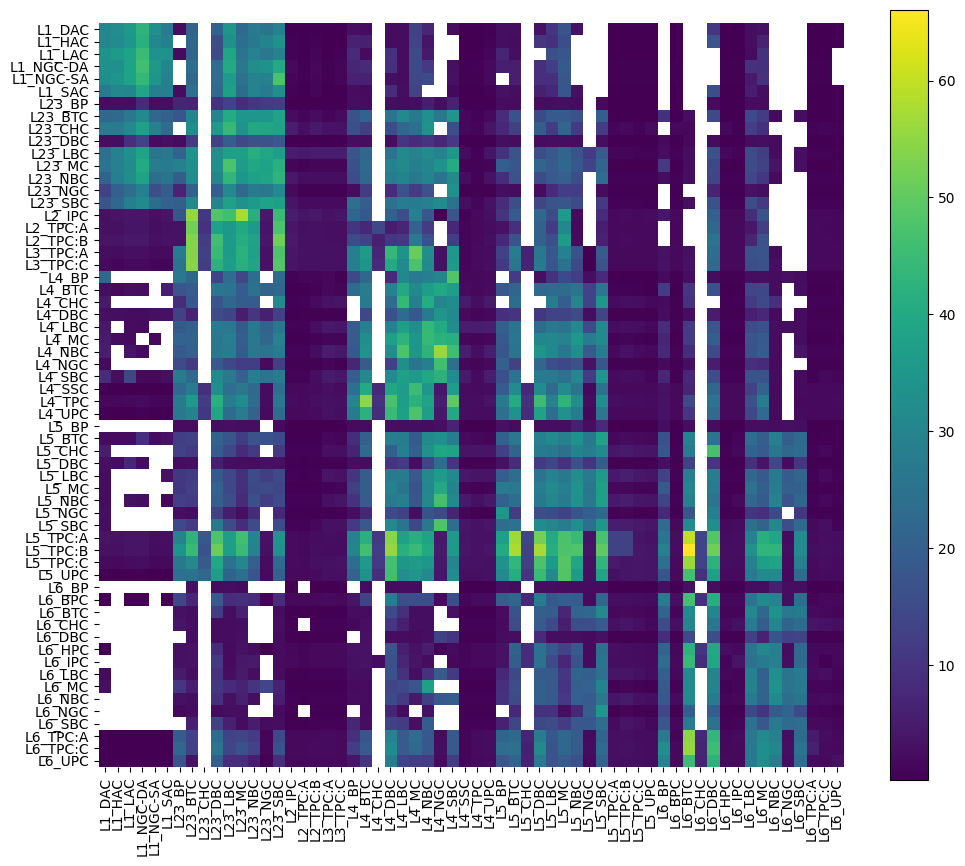

In [12]:
fig = image_plot_dataframe(connection_fun_str[name_analysis].unstack(str_pw_pre))

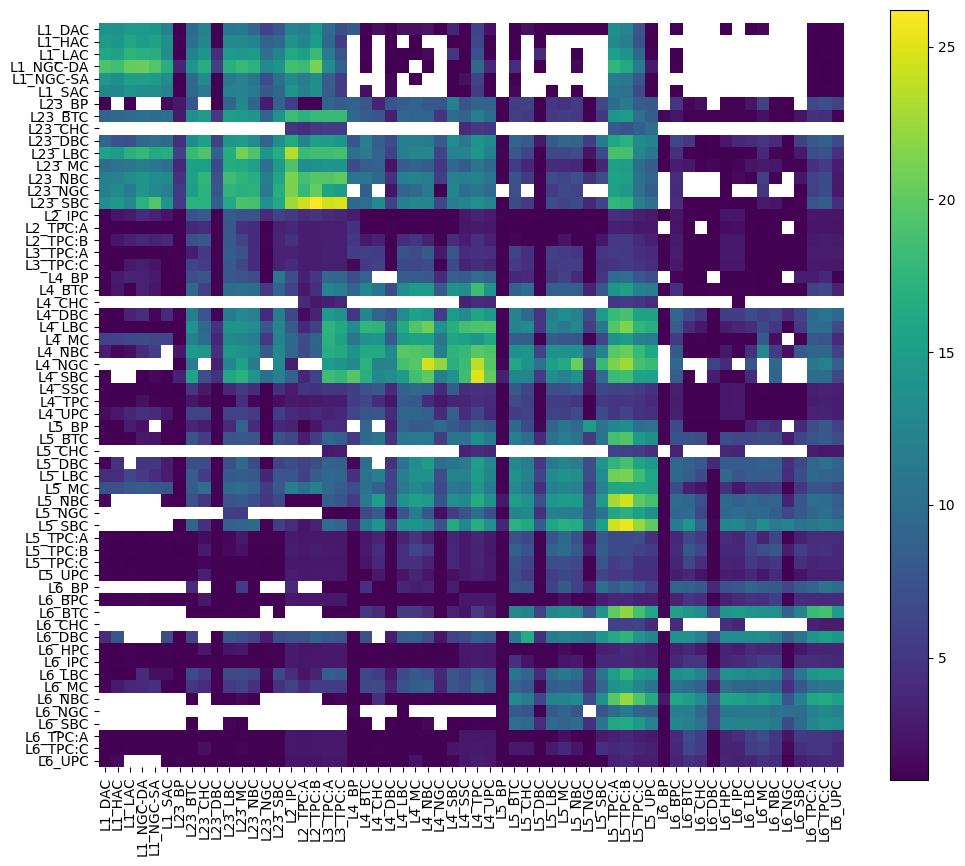

In [13]:
# Plot _structural_ strength instead
fig = image_plot_dataframe(connection_struc_str[name_analysis].unstack(str_pw_post))